Nama     : **Muhamad Ilyas**               
Email    : **181240000831@unisnu.ac.id**   
Domisili : **Kabupaten Jepara, Jawa Tengah**

In [1]:
#memanggil file dari google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import numpy
from tensorflow import keras

In [54]:
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ui_1we0l
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ui_1we0l


In [55]:
#mengubah dataset menjadi dataframe
dataframe = pd.read_csv('/content/drive/MyDrive/Dataset/google.csv')
dataframe

,Date,High,Low,Open,Close,Volume,Adj Close
0,2004-08-19,51.835709,47.800831,49.813290,49.982655,44871361.0,49.982655
1,2004-08-20,54.336334,50.062355,50.316402,53.952770,22942874.0,53.952770
2,2004-08-23,56.528118,54.321388,55.168217,54.495735,18342897.0,54.495735
3,2004-08-24,55.591629,51.591621,55.412300,52.239197,15319808.0,52.239197
4,2004-08-25,53.798351,51.746044,52.284027,52.802086,9232276.0,52.802086
...,...,...,...,...,...,...,...
4293,2021-09-08,2911.020020,2884.000000,2907.870117,2897.669922,774300.0,2897.669922
4294,2021-09-09,2913.389893,2888.679932,2897.669922,2898.270020,739900.0,2898.270020
4295,2021-09-10,2920.379883,2834.830078,2908.870117,2838.419922,1643500.0,2838.419922
4296,2021-09-13,2883.820068,2845.649902,2864.020020,2869.300049,1008800.0,2869.300049


In [56]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4298 entries, 0 to 4297
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4298 non-null   object 
 1   High       4298 non-null   float64
 2   Low        4298 non-null   float64
 3   Open       4298 non-null   float64
 4   Close      4298 non-null   float64
 5   Volume     4298 non-null   float64
 6   Adj Close  4298 non-null   float64
dtypes: float64(6), object(1)
memory usage: 235.2+ KB


In [57]:
#mengecek apakah ada nilai yang hilang dari dataset
dataframe.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [58]:
#melakukan perubahan tanggal
dataframe['Date'] = pd.to_datetime(dataframe['Date'])

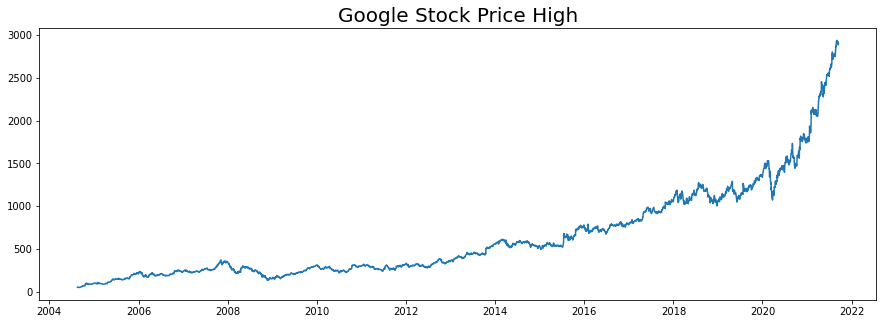

In [59]:
#membuat plot dari data
dates = dataframe['Date'].values
temp = dataframe['High'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Google Stock Price High',
          fontsize=20);

In [60]:
#melihat plot dari keseluruhan data
fig = go.Figure(data=[go.Candlestick(x=dataframe['Date'],
                                    open=dataframe['Open'], 
                                    high=dataframe['High'],
                                    low=dataframe['Low'],
                                    close=dataframe['Close'],
                                    increasing_line_color = 'purple',
                                    decreasing_line_color = 'black')
                                    ])
fig.update_layout(title={'text':'Google Prices All Time'})
fig.show()

In [61]:
#membagi dataset
scaler = MinMaxScaler(feature_range=(0,1))

dataframe_new = dataframe['Close']
dataframe_new = scaler.fit_transform(np.array(dataframe_new).reshape(-1,1))


In [62]:
def create_dataset(dataset,time_step=1):
    x,y = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        x.append(a)
        y.append(dataset[i + time_step,0])
    return numpy.array(x), numpy.array(y)

In [69]:
time_step = 100
x_train, y_train = create_dataset(dataframe_new, time_step)
x_test, y_test = create_dataset(dataframe_new, time_step)

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [64]:
#mengembalikan label dan atribut dari dataset dalam bentuk batch
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [65]:
#arsitektur model gunakan 2 buah layer LSTM
x_train  = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
])

In [66]:
# menggunakan EarlyStopping callback yang akan mengecek kondisi dari proses pelatihan model setiap epoch
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [71]:
#optimizer dan loss
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(x_train,y_train, 
                    validation_data=(x_test, y_test),
                    batch_size=64,
                    verbose=1,
                    callbacks=[early_stop,tfdocs.modeling.EpochDots()],
                    epochs=100)

Epoch 1/100
66/66 [==============================] - 13s 160ms/step - loss: 0.0111 - mae: 0.1151 - val_loss: 0.0111 - val_mae: 0.1150

Epoch: 0, loss:0.0111,  mae:0.1151,  val_loss:0.0111,  val_mae:0.1150,  
.Epoch 2/100
66/66 [==============================] - 10s 146ms/step - loss: 0.0111 - mae: 0.1148 - val_loss: 0.0111 - val_mae: 0.1147
.Epoch 3/100
66/66 [==============================] - 10s 145ms/step - loss: 0.0110 - mae: 0.1145 - val_loss: 0.0110 - val_mae: 0.1144
.Epoch 4/100
66/66 [==============================] - 10s 151ms/step - loss: 0.0110 - mae: 0.1143 - val_loss: 0.0110 - val_mae: 0.1142
.Epoch 5/100
66/66 [==============================] - 10s 149ms/step - loss: 0.0109 - mae: 0.1140 - val_loss: 0.0109 - val_mae: 0.1139
.Epoch 6/100
66/66 [==============================] - 10s 149ms/step - loss: 0.0109 - mae: 0.1138 - val_loss: 0.0108 - val_mae: 0.1136
.Epoch 7/100
66/66 [==============================] - 10s 146ms/step - loss: 0.0108 - mae: 0.1135 - val_loss: 0.0108 